# Projekt Machine Learning – Online Retail II
## Kompletny szkielet notebooka
---
## 0. Overview
**TODO:** Opis projektu, cel, dane, metody, plan pracy.


# 1. Wczytanie danych
**TODO:** Importy, ładowanie, wstępny opis.


Dane pochodzą z publicznego zbioru Online Retail II, który zawiera szczegółowe informacje o transakcjach dokonanych w internetowym sklepie sprzedającym artykuły
dekoracyjne i prezenty. Zbiór obejmuje okres od 01.12.2009 do 09.12.2011 i zawiera ponad 1 milion rekordów.

In [5]:
import pandas as pd

# wczytanie danych
file_path = "../data/online_retail_II.xlsx"
df1 = pd.read_excel(file_path, sheet_name="Year 2009-2010")
df2 = pd.read_excel(file_path, sheet_name="Year 2010-2011")

# łączenie danych
df = pd.concat([df1, df2], ignore_index=True)

# konwersja typu kolumny InvoiceDate na datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# tworzenie kolumny TotalPrice
df["TotalPrice"] = df["Quantity"] * df["Price"]

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
 8   TotalPrice   1067371 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 73.3+ MB


## 2. EDA & Czyszczenie
**TODO:** Braki, korelacje, błędy, outliery, czyszczenie.

**2.1. Czyszczenie danych**

In [6]:
# Usuń anulowane faktury (Invoice zaczyna się od "C")
df = df[~df["Invoice"].astype(str).str.startswith("C")]

# Usuń rekordy z Quantity <= 0 i Price <= 0
df = df[(df["Quantity"] > 0) & (df["Price"] > 0)]

# Usuń rekordy bez Customer ID
df = df[df["Customer ID"].notna()]

# Zamiana typ Customer ID na int
df["Customer ID"] = df["Customer ID"].astype(int)

# Filtrowanie tylko na UK
df = df[df["Country"] == "United Kingdom"]

df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
Index: 725250 entries, 0 to 1067354
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      725250 non-null  object        
 1   StockCode    725250 non-null  object        
 2   Description  725250 non-null  object        
 3   Quantity     725250 non-null  int64         
 4   InvoiceDate  725250 non-null  datetime64[ns]
 5   Price        725250 non-null  float64       
 6   Customer ID  725250 non-null  int64         
 7   Country      725250 non-null  object        
 8   TotalPrice   725250 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 55.3+ MB


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


**2.2. EDA**

2.2.1. Histogram Quantity


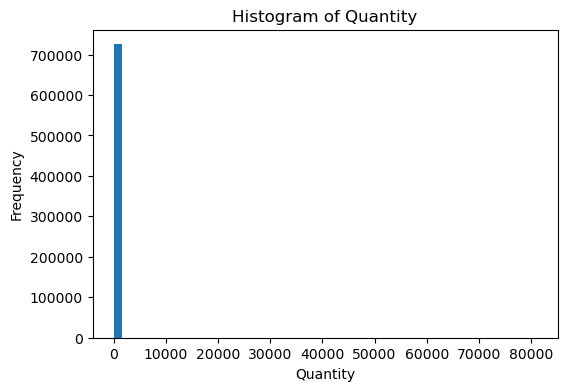

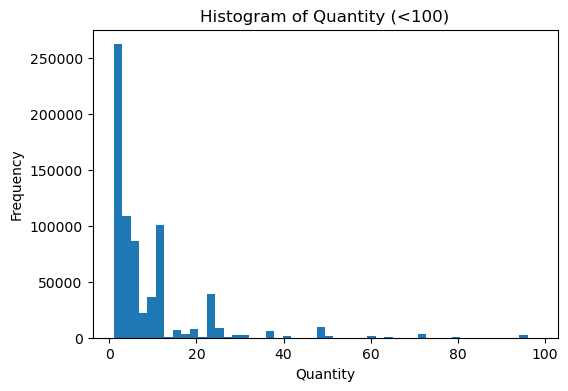

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(df["Quantity"], bins=50)
plt.title("Histogram of Quantity")
plt.xlabel("Quantity")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df[df["Quantity"] < 100]["Quantity"], bins=50)
plt.title("Histogram of Quantity (<100)")
plt.xlabel("Quantity")
plt.ylabel("Frequency")
plt.show()


Histogram dla wszystkich wartości Quantity pokazał zaburzony i nieczytelny wykres - większość danych "ściśnięta" przy osi X. Rozciągnięcie osi X do ok. 80 000 wynika prawdopodobnie z występowania outlierów. Taki kształt histogramu wskazuje na pojedyńcze masowe transakcje magazynowe lub błędy. W celu uzyskania realnego obrazu typowych zamówień, został wykonany drugi histogram, w którym zostały uwzględnione jedynie rekordy z Quantity < 100. Dzięki temu, widać że większość transakcji obejmuje bardzo małe ilości produktów (najczęściej 1-5 sztuk), wykres nie jest zdominowany przez skrajne wartości i można lepiej zrozumieć typowe zachowanie klientów.

2.2.2. Histogram UnitPrice

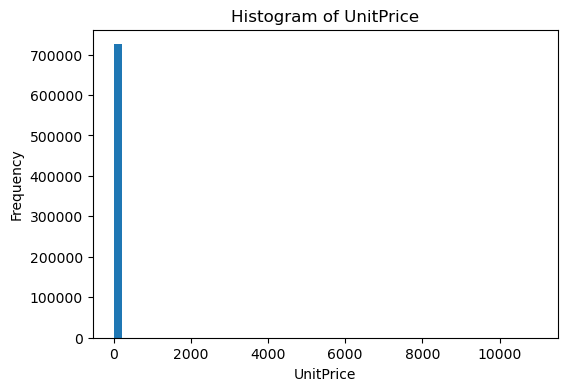

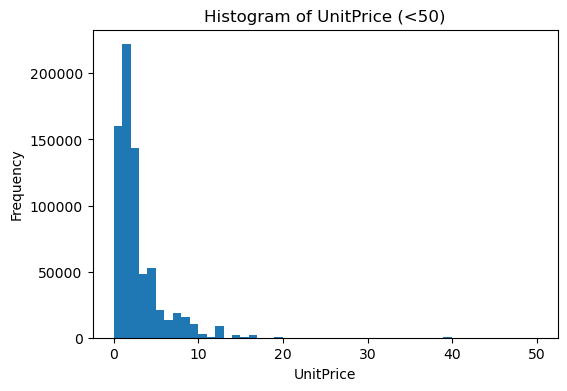

In [14]:
plt.figure(figsize=(6,4))
plt.hist(df["Price"], bins=50)
plt.title("Histogram of UnitPrice")
plt.xlabel("UnitPrice")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df[df["Price"] < 50]["Price"], bins=50)
plt.title("Histogram of UnitPrice (<50)")
plt.xlabel("UnitPrice")
plt.ylabel("Frequency")
plt.show()

Pierwszy histogram wykonany dla wszystkich wartości UnitPrice też okazał się zdeformowany i mało czytelny, dlatego wykonano drugi dla ceny niższej niż 50 GBP. Co można wywnioskować: występują pojedyńcze bardzo drogie produkty, możliwe błędy danych, większość produktów kosztuje od 1 do 5 GBP, ceny powyżej 10 GBP są rzadkie, a w przedziale 20-50 to pojedyńcze przypadki.

2.3.3. Histogram TotalPrice

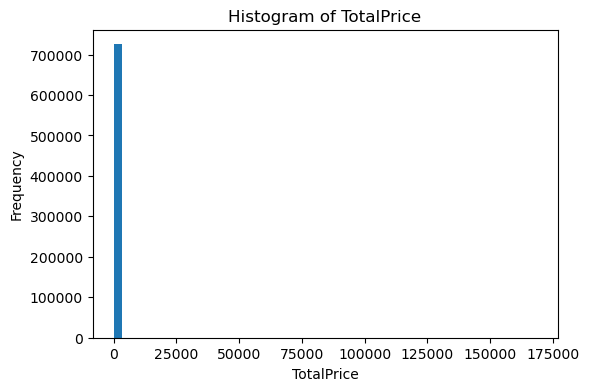

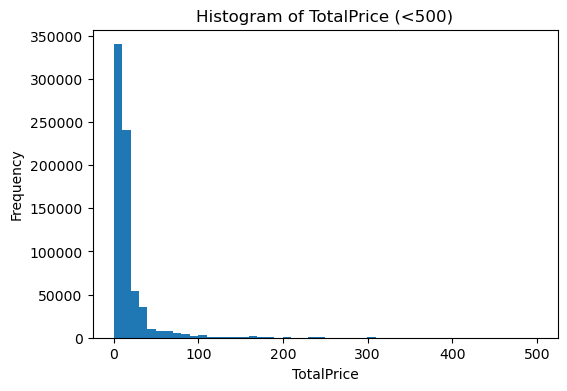

In [16]:
plt.figure(figsize=(6,4))
plt.hist(df["TotalPrice"], bins=50)
plt.title("Histogram of TotalPrice")
plt.xlabel("TotalPrice")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df[df["TotalPrice"] < 500]["TotalPrice"], bins=50)
plt.title("Histogram of TotalPrice (<500)")
plt.xlabel("TotalPrice")
plt.ylabel("Frequency")
plt.show()

Histogram TotalPrice w pełnym zakresie wartości okazał się całkowicie nieczytelny. Podobnie jak przy Quantity i UnitPrice, wykres został zdominowany przez pojedyncze, skrajnie wysokie wartości (np. transakcje o wartości ponad 100 000 GBP). Skutkiem tego wszystkie typowe transakcje — o wartościach 1–100 GBP — były niewidoczne przy osi X.

Aby zobaczyć prawdziwy rozkład wartości zamówień, konieczne było ponowne wykonanie histogramu na danych ograniczonych, np. TotalPrice < 500. Dopiero taki wykres ujawnia, że większość zamówień ma bardzo niską wartość, a ekstremalnie duże transakcje są rzadkimi outlierami.

2.2.4. Sprzedaż w czasie

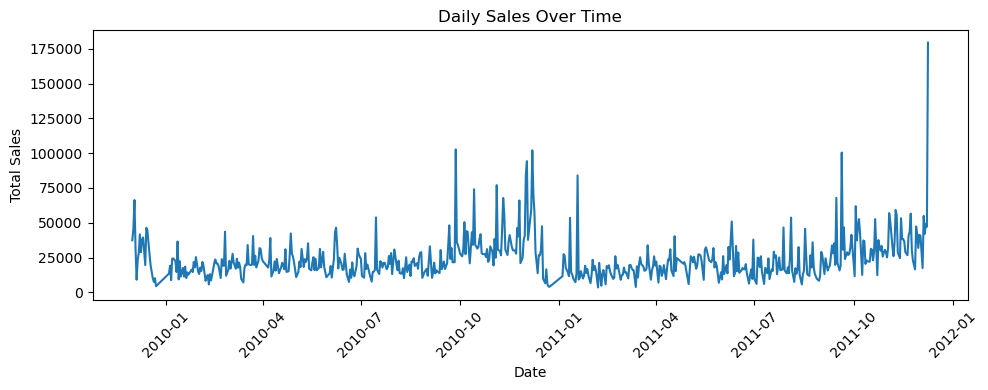

In [17]:
daily_sales = df.groupby(df["InvoiceDate"].dt.date)["TotalPrice"].sum()

plt.figure(figsize=(10,4))
plt.plot(daily_sales.index, daily_sales.values)
plt.title("Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

W obu latach widoczne są wzrosty sprzedaży w czwartym kwartale, może być to związane z okresem świątecznym. Na wykresie są widoczne pojedyńcze piki, które mogą wynikać z dużych zamówień hurtowych, pojedyńczych zamówieniach o wysokiej wartości, dniach o wyjątkowo dużym ruchu (np. przed świętami) lub rzadkich outlierów.

2.2.5 Top 20 produktów

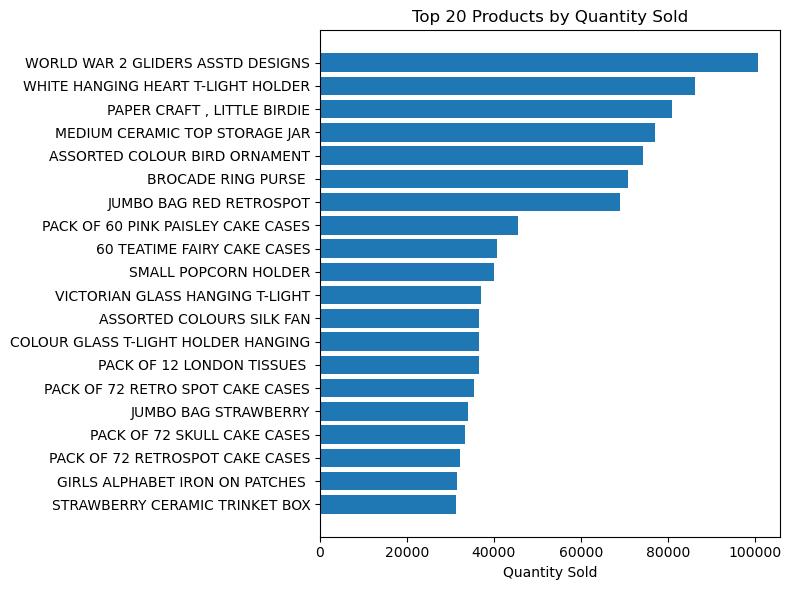

In [18]:
top_products = df.groupby("Description")["Quantity"].sum().sort_values(ascending=False).head(20)

plt.figure(figsize=(8,6))
plt.barh(top_products.index[::-1], top_products.values[::-1])
plt.title("Top 20 Products by Quantity Sold")
plt.xlabel("Quantity Sold")
plt.tight_layout()
plt.show()

2.2.6. Heatmap korelacji

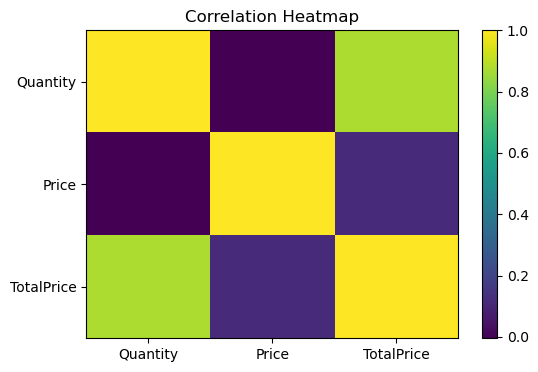

In [20]:
import numpy as np

corr = df[["Quantity","Price","TotalPrice"]].corr()

plt.figure(figsize=(6,4))
plt.imshow(corr, cmap="viridis", aspect="auto")
plt.colorbar()
plt.xticks(range(3), ["Quantity","Price","TotalPrice"])
plt.yticks(range(3), ["Quantity","Price","TotalPrice"])
plt.title("Correlation Heatmap")
plt.show()

Z Heatmap'y korelacji można wywnioskować, że TotalPrice jest silnie determinowane przez Quantiy. Ma to sens, ponieważ im więcej sztuk jest kupowane tym większa wartość transakcji. Totalprice rośnie także, gdy rośnie cena jednostkowa produktu. Nie ma związku między ceną jednostkową, a liczbą sztuk.

## 3. Feature Engineering (RFM)
**TODO:** R, F, M, agregacje, snapshot_date.

## 4. Outliers – Isolation Forest
**TODO:** Wykrywanie klientów odstających.

## 5. Standaryzacja
**TODO:** StandardScaler na cechach liczbowych.

## 6. Feature Selection
**TODO:** LASSO, Permutation Importance, PCA.

## 7. Clustering – KMeans
**TODO:** Elbow, Silhouette, klastry i ich opis.

## 8. Modelowanie supervised
**TODO:** Target high-value, modele baseline i docelowe.

## 9. Optuna – tuning modeli
**TODO:** Strojenie hiperparametrów XGBoost i LogReg.

## 10. Interpretacja – SHAP, PDP
**TODO:** SHAP values, partial dependence, wnioski.

## 11. Podsumowanie
**TODO:** Wnioski biznesowe i techniczne.

In [2]:
# TODO: Kod wykonujący dany krok
pass